# Check sync process

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datetime
import pathlib
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


from u19_pipeline import acquisition, ephys
from u19_pipeline.ephys import ephys_element, probe_element, get_session_directory
# import u19_pipeline.ephys_sync as ephys
import u19_pipeline.acquisition as acquisition
import datajoint as dj

import u19_pipeline.utils.DemoReadSGLXData.readSGLX as readSGLX
import u19_pipeline.utils.ephys_utils as ephys_utils
from bitstring import BitArray

Connecting alvaros@datajoint00.pni.princeton.edu:3306


In [3]:
key = {'subject_fullname': 'testuser_T01',
    'session_date': datetime.date(2022, 5, 12)}

key = {
    'subject_fullname': 'jjulian_jj046',
    'session_date': datetime.date(2022, 4, 19)}

key2 = 'subject_fullname = "jjulian_jj046" and session_date = "2022-04-19" and block >=2'
#key = {
#    'subject_fullname': 'jjulian_jj042',
#    'session_date': datetime.date(2021, 10, 31)}


key = (acquisition.Session & key).fetch1('KEY')
key

{'subject_fullname': 'jjulian_jj046',
 'session_date': datetime.date(2022, 4, 19),
 'session_number': 0}

# Synchronize ePhys and Behavior

Populate the tables, using the nidaq file produced by spikeGLX. This is done automatically and produces a record of VR iteration numbers measured in the time of the ePhys setup.

In [6]:
#ephys = dj.create_virtual_module('ephys', 'u19_ephys')

ephys.BehaviorSync()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,nidq_sampling_rate sampling rate of behavioral iterations niSampRate in nidq meta file,iteration_index_nidq length of this longblob should be the number of iterations in the behavior recording,trial_index_nidq length of this longblob should be the number of iterations in the behavior recording
hnieh_E105,2021-01-15,0,5000.08,=BLOB=,=BLOB=
jjulian_jj042,2021-10-31,0,5000.06,=BLOB=,=BLOB=
jjulian_jj042,2021-11-01,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-14,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-15,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-16,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-17,0,5000.06,=BLOB=,=BLOB=
jjulian_jj049,2022-01-14,0,5000.06,=BLOB=,=BLOB=
jjulian_jj049,2022-01-15,0,5000.06,=BLOB=,=BLOB=
jjulian_jj049,2022-01-16,0,5000.06,=BLOB=,=BLOB=


In [7]:
ephys.EphysSession()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,ephys_directory Path were session file will be stored in bucket
hnieh_E105,2021-01-15,0,/Volumes/Tank/schottdorf/NPX/2021_01_15_E105/towersTask_g0
jjulian_jj042,2021-10-31,0,/RigData/training/npx/electrophysiology/josh/jjulian_jj042/20211031/jjulian_jj042_20211031_g0
jjulian_jj042,2021-11-01,0,/RigData/training/npx/electrophysiology/josh/jjulian_jj042/20211101/jjulian_jj042_20211101_g0
jjulian_jj046,2022-04-19,0,/RigData/training/npx/electrophysiology/josh/jjulian_jj046/jjulian_jj046_04192022_g0
jjulian_jj048,2022-01-14,0,/RigData/training/npx/electrophysiology/jjulian/jjulian_jj048/01142022/jjulian_jj048_01142022_g0
jjulian_jj048,2022-01-15,0,/RigData/training/npx/electrophysiology/jjulian/jjulian_jj048/01152022/jjulian_jj048_01152022_g0
jjulian_jj048,2022-01-16,0,/RigData/training/npx/electrophysiology/jjulian/jjulian_jj048/01162022/jjulian_jj048_01162022_g0
jjulian_jj048,2022-01-17,0,/RigData/training/npx/electrophysiology/jjulian/jjulian_jj048/01172022/jjulian_jj048_01172022_g0
jjulian_jj049,2022-01-14,0,/RigData/training/npx/electrophysiology/jjulian/jjulian_jj049/01142022/jjulian_jj049_01142022_g0
jjulian_jj049,2022-01-15,0,/RigData/training/npx/electrophysiology/jjulian/jjulian_jj049/01152022/jjulian_jj049_01152022_g0


### Read nidaq file and behavior data

In [8]:
session_dir = pathlib.Path(get_session_directory(key))
print(session_dir)
#session_dir = pathlib.Path('/Users/alvaros/Documents/MATLAB/BrainCogsProjects/CalciumImagingData/test_g0/')
nidq_bin_full_path = list(session_dir.glob('*nidq.bin*'))[0]

#Nidaq file
nidq_meta          = readSGLX.readMeta(nidq_bin_full_path)
nidq_sampling_rate = readSGLX.SampRate(nidq_meta)
digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(nidq_bin_full_path, nidq_meta)

#Behavior data
behavior = dj.create_virtual_module('behavior', 'u19_behavior')
thissession = behavior.TowersBlock().Trial() & key2
behavior_time, iterstart, beh_num_iterations = thissession.fetch('trial_time', 'vi_start', 'iterations')


/Volumes/braininit/RigData/training/npx/electrophysiology/josh/jjulian_jj046/jjulian_jj046_04192022_g0
nChan: 1, nFileSamp: 18400502


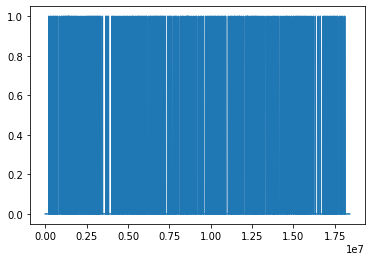

In [9]:
plt.plot(digital_array[1,:])

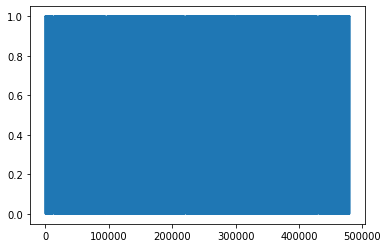

In [11]:
plt.plot(digital_array[2,620000:1100000])

In [12]:
digital_array

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [13]:
thissession

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,block block number,"trial_idx trial index, keep the original number in the file","trial_type answer of this trial, left or right","choice choice of this trial, left or right",trial_abs_start absolute start time of the trial realtive to the beginning of the session,cue_presence_left boolean vector for the presence of the towers on the left,cue_presence_right boolean vector for the presence of the towers on the right,cue_onset_left onset time of the cues on the left (only for the present ones),cue_onset_right onset time of the cues on the right (only for the present ones),cue_offset_left offset time of the cues on the left (only for the present ones),cue_offset_right offset time of the cues on the right (only for the present ones),cue_pos_left position of the cues on the left (only for the present ones),cue_pos_right position of the cues on the right (only for the present ones),trial_duration duration of the entire trial,excess_travel metric that indicates if mice travelled on a straight line,i_arm_entry the index of the time series when the mouse enters the arm part,i_blank the index of the time series when the mouse enters the blank zone,i_cue_entry the index of the time series when the mouse neters the cue zone,i_mem_entry the index of the time series when the mouse enters the memory zone,i_turn_entry the index of the time series when the mouse enters turns,iterations length of the meaningful recording,trial_id,trial_prior_p_left prior probablity of this trial for left,vi_start,"trial_time time series of this trial, start from zero for each trial",collision boolean vector indicating whether the subject hit the maze on each time point,"position 3d recording of the position of the mouse, length equals to interations","velocity 3d recording of the velocity of the mouse, length equals to interations",sensor_dots raw recordings of the ball
jjulian_jj046,2022-04-19,0,2,1,L,L,0.314472,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,20.4824,0.0554246,1116,0,722,760,1116,1209,-4,0.5,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
jjulian_jj046,2022-04-19,0,2,2,L,L,20.7969,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,18.9399,-0.131662,1022,0,408,458,1022,1110,1,0.5,1438,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
jjulian_jj046,2022-04-19,0,2,3,R,R,39.7367,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,17.0181,-0.0978048,829,0,450,485,829,975,2,0.5,2775,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
jjulian_jj046,2022-04-19,0,2,4,L,L,56.7549,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,16.3938,-0.130909,763,0,394,430,763,922,3,0.5,3976,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
jjulian_jj046,2022-04-19,0,2,5,R,R,73.1487,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,14.6342,-0.152547,744,0,342,372,744,789,9,0.5,5123,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
jjulian_jj046,2022-04-19,0,2,6,L,L,87.7829,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,16.5865,-0.121202,794,0,358,390,794,946,4,0.5,6140,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
jjulian_jj046,2022-04-19,0,2,7,L,L,104.369,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,24.9804,-0.107094,1435,0,1064,1095,1435,1551,1,0.5,7311,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
jjulian_jj046,2022-04-19,0,2,8,R,L,129.35,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,23.723,-0.122898,755,0,428,462,755,903,13,0.5,9089,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
jjulian_jj046,2022-04-19,0,2,9,R,R,153.073,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,18.1598,-0.0141309,913,0,522,557,913,1057,5,0.5,10814,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
jjulian_jj046,2022-04-19,0,2,10,R,R,171.233,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,13.6427,-0.152834,668,0,358,384,668,707,6,0.5,12099,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [14]:
digital_array.shape

(8, 18400502)

### Get samples and times where trials and iterations start

In [15]:
mode = 'counter_bit0'    #Default for sessions before 12/01/2021
#mode = 'pulses'    #Default for sessions after 12/01/2021
iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_pulses(digital_array[1,:], digital_array[2,:], nidq_sampling_rate, behavior_time.shape[0], mode=mode)
#                             get_iteration_sample_vector_from_digital_lines_pulses(trial_pulse_signal, iteration_pulse_signal,

status = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)
status


1
1436
1436
2
1337
1337
3
1201
1201
4
1147
1147
5
1017
1017
6
1171
1171
7
1778
1778
8
1725
1725
9
1285
1285
10
935
935
11
1008
1008
12
904
904
13
1149
1149
14
1105
1105
15
976
976
16
1210
1210
17
1088
1088
18
1090
1090
19
1190
1190
20
1025
1025
21
1645
1645
22
1816
1816
23
1859
1859
24
1854
1854
25
1630
1630
26
1022
1022
27
1048
1048
28
997
997
29
1080
1080
30
979
979
31
1047
1047
32
1021
1021
33
1022
1022
34
1082
1082
35
1105
1105
36
1013
1013
37
1786
1786
38
3131
3131
39
985
985
40
1150
1150
41
3314
3314
42
1003
1003
43
1670
1670
44
1713
1713
45
1750
1750
46
1780
1780
47
1750
1750
48
1108
1108
49
1609
1609
50
1312
1312
51
1662
1662
52
1458
1458
53
1049
1049
54
1124
1124
55
1625
1625
56
1339
1339
57
1083
1083
58
1104
1104
59
1046
1046
60
1289
1289
61
1180
1180
62
1167
1167
63
1102
1102
64
1784
1784
65
2114
2114
66
1514
1514
67
1145
1145
68
1056
1056
69
1020
1020
70
1002
1002
71
1206
1206
72
1036
1036
73
1057
1057
74
1000
1000
75
1066
1066
76
1114
1114
77
2133
2133
78
1118
1118
79
1196

True

### Plot signals around start of a trial

time from niDAQ 24.91208755758027
time behavior [24.926266]
samples nidaq 124562
iter nidaq (1778,)
iter_virmen (1778, 1)


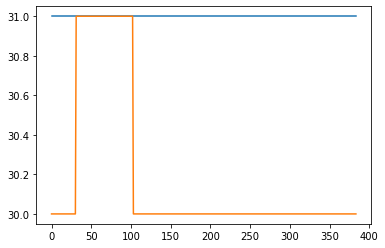

In [16]:
trial_plot = 6
samp_before = 30
end_iter = 5
samp_after = 30

plt.plot(digital_array[0,iteration_dict['iter_start_idx'][trial_plot][0]-samp_before:iteration_dict['iter_start_idx'][trial_plot][end_iter]]+samp_after)
plt.plot(digital_array[1,iteration_dict['iter_start_idx'][trial_plot][0]-samp_before:iteration_dict['iter_start_idx'][trial_plot][end_iter]]+samp_after)


iter_nidaq = (iteration_dict['iter_start_idx'][trial_plot][-1]-iteration_dict['iter_start_idx'][trial_plot][0])
time = iter_nidaq/nidq_sampling_rate
iter_virmen = time*120

print('time from niDAQ', time)
print('time behavior', behavior_time[trial_plot][-1])

print('samples nidaq', iter_nidaq)
print('iter nidaq', iteration_dict['iter_start_idx'][trial_plot].shape)
print('iter_virmen',behavior_time[trial_plot].shape)

### Plot average time differences between behavior file and nidaq time

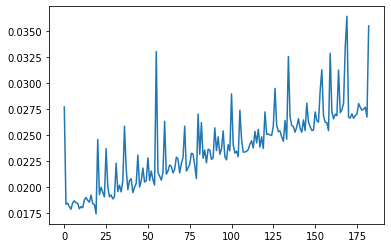

In [17]:
x = np.array([])
mean_x = np.array([])
for i in range(iteration_dict['iter_times_idx'].shape[0]-1):
    s = behavior_time[i].flatten()-iteration_dict['iter_times_idx'][i]
    mean_time_trial = np.mean(s)
    x = np.append(x,s, axis=0)
    mean_x = np.append(mean_x, mean_time_trial)

#plt.plot(x)
plt.plot(mean_x)


### Test BehaviorSync insertion

In [4]:
ephys.BehaviorSync.populate(key)

nChan: 1, nFileSamp: 18400502
1
1436
1436
2
1337
1337
3
1201
1201
4
1147
1147
5
1017
1017
6
1171
1171
7
1778
1778
8
1725
1725
9
1285
1285
10
935
935
11
1008
1008
12
904
904
13
1149
1149
14
1105
1105
15
976
976
16
1210
1210
17
1088
1088
18
1090
1090
19
1190
1190
20
1025
1025
21
1645
1645
22
1816
1816
23
1859
1859
24
1854
1854
25
1630
1630
26
1022
1022
27
1048
1048
28
997
997
29
1080
1080
30
979
979
31
1047
1047
32
1021
1021
33
1022
1022
34
1082
1082
35
1105
1105
36
1013
1013
37
1786
1786
38
3131
3131
39
985
985
40
1150
1150
41
3314
3314
42
1003
1003
43
1670
1670
44
1713
1713
45
1750
1750
46
1780
1780
47
1750
1750
48
1108
1108
49
1609
1609
50
1312
1312
51
1662
1662
52
1458
1458
53
1049
1049
54
1124
1124
55
1625
1625
56
1339
1339
57
1083
1083
58
1104
1104
59
1046
1046
60
1289
1289
61
1180
1180
62
1167
1167
63
1102
1102
64
1784
1784
65
2114
2114
66
1514
1514
67
1145
1145
68
1056
1056
69
1020
1020
70
1002
1002
71
1206
1206
72
1036
1036
73
1057
1057
74
1000
1000
75
1066
1066
76
1114
1114
77


In [5]:
ephys.BehaviorSync()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,nidq_sampling_rate sampling rate of behavioral iterations niSampRate in nidq meta file,iteration_index_nidq length of this longblob should be the number of iterations in the behavior recording,trial_index_nidq length of this longblob should be the number of iterations in the behavior recording
hnieh_E105,2021-01-15,0,5000.08,=BLOB=,=BLOB=
jjulian_jj042,2021-10-31,0,5000.06,=BLOB=,=BLOB=
jjulian_jj042,2021-11-01,0,5000.06,=BLOB=,=BLOB=
jjulian_jj046,2022-04-19,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-14,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-15,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-16,0,5000.06,=BLOB=,=BLOB=
jjulian_jj048,2022-01-17,0,5000.06,=BLOB=,=BLOB=
jjulian_jj049,2022-01-14,0,5000.06,=BLOB=,=BLOB=
jjulian_jj049,2022-01-15,0,5000.06,=BLOB=,=BLOB=
